# Notes

We provide this notebook for inference and visualizations. 

You can either load images from a dataloader(see Sec. 1) or from a local path(see Sec. 2).

Welcome to join [IDEA](https://idea.edu.cn/en)([中文网址](https://idea.edu.cn/))!

In [1]:
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

# 0. Initialize and Load Pre-trained Models

In [2]:
model_config_path = "config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "checkpoint/checkpoint0033_4scale.pth" # change the path of the model checkpoint
# See our Model Zoo section in README.md for more details about our pretrained models.

In [3]:
args = SLConfig.fromfile(model_config_path) 
args.device = 'cuda' 
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/home/biaslab/miniconda3/envs/dino/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/biaslab/miniconda3/envs/dino/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/biaslab/miniconda3/envs/dino/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/biaslab/miniconda3/envs/dino/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0

HD_init


/tmp/ipykernel_1958482/2480974019.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint_path, map_location='cpu')


RuntimeError: Error(s) in loading state_dict for DINO:
	Missing key(s) in state_dict: "transformer.decoder.class_embed.0.encoder.weight", "transformer.decoder.class_embed.0.encoder.bias", "transformer.decoder.class_embed.0.model.weight", "transformer.decoder.class_embed.0.model.bias", "transformer.decoder.class_embed.1.encoder.weight", "transformer.decoder.class_embed.1.encoder.bias", "transformer.decoder.class_embed.1.model.weight", "transformer.decoder.class_embed.1.model.bias", "transformer.decoder.class_embed.2.encoder.weight", "transformer.decoder.class_embed.2.encoder.bias", "transformer.decoder.class_embed.2.model.weight", "transformer.decoder.class_embed.2.model.bias", "transformer.decoder.class_embed.3.encoder.weight", "transformer.decoder.class_embed.3.encoder.bias", "transformer.decoder.class_embed.3.model.weight", "transformer.decoder.class_embed.3.model.bias", "transformer.decoder.class_embed.4.encoder.weight", "transformer.decoder.class_embed.4.encoder.bias", "transformer.decoder.class_embed.4.model.weight", "transformer.decoder.class_embed.4.model.bias", "transformer.decoder.class_embed.5.encoder.weight", "transformer.decoder.class_embed.5.encoder.bias", "transformer.decoder.class_embed.5.model.weight", "transformer.decoder.class_embed.5.model.bias", "transformer.enc_out_class_embed.encoder.weight", "transformer.enc_out_class_embed.encoder.bias", "transformer.enc_out_class_embed.model.weight", "transformer.enc_out_class_embed.model.bias", "class_embed.0.encoder.weight", "class_embed.0.encoder.bias", "class_embed.0.model.weight", "class_embed.0.model.bias", "class_embed.1.encoder.weight", "class_embed.1.encoder.bias", "class_embed.1.model.weight", "class_embed.1.model.bias", "class_embed.2.encoder.weight", "class_embed.2.encoder.bias", "class_embed.2.model.weight", "class_embed.2.model.bias", "class_embed.3.encoder.weight", "class_embed.3.encoder.bias", "class_embed.3.model.weight", "class_embed.3.model.bias", "class_embed.4.encoder.weight", "class_embed.4.encoder.bias", "class_embed.4.model.weight", "class_embed.4.model.bias", "class_embed.5.encoder.weight", "class_embed.5.encoder.bias", "class_embed.5.model.weight", "class_embed.5.model.bias". 
	Unexpected key(s) in state_dict: "transformer.decoder.class_embed.0.weight", "transformer.decoder.class_embed.0.bias", "transformer.decoder.class_embed.1.weight", "transformer.decoder.class_embed.1.bias", "transformer.decoder.class_embed.2.weight", "transformer.decoder.class_embed.2.bias", "transformer.decoder.class_embed.3.weight", "transformer.decoder.class_embed.3.bias", "transformer.decoder.class_embed.4.weight", "transformer.decoder.class_embed.4.bias", "transformer.decoder.class_embed.5.weight", "transformer.decoder.class_embed.5.bias", "transformer.enc_out_class_embed.weight", "transformer.enc_out_class_embed.bias", "class_embed.0.weight", "class_embed.0.bias", "class_embed.1.weight", "class_embed.1.bias", "class_embed.2.weight", "class_embed.2.bias", "class_embed.3.weight", "class_embed.3.bias", "class_embed.4.weight", "class_embed.4.bias", "class_embed.5.weight", "class_embed.5.bias". 

In [4]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}

# 1. Visualize images from a dataloader
## 1.1 Load Datasets

In [5]:
args.dataset_file = 'coco'
#"/comp_robot/cv_public_dataset/COCO2017/"
args.coco_path = "/mnt/Data_1/coco/" # the path of coco
args.fix_size = False

dataset_val = build_dataset(image_set='val', args=args)   

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


## 1.2 Get an Example and Visualize it

In [6]:
image, targets = dataset_val[0]
image.shape

torch.Size([3, 800, 1201])

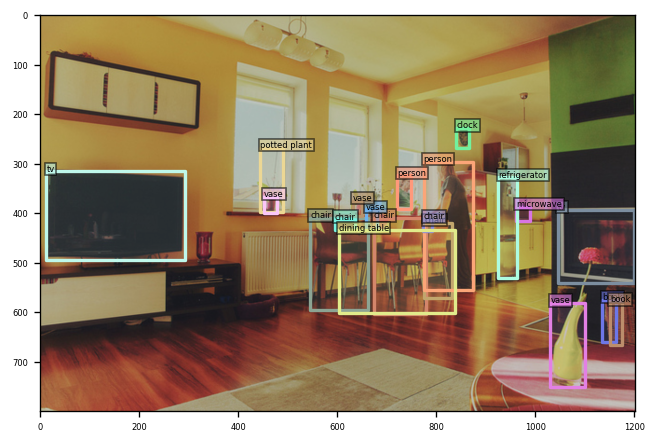

In [7]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

## 1.3 Visualize Model Predictions

In [8]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/home/biaslab/miniconda3/envs/dino/lib/python3.8/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789116784/work/aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

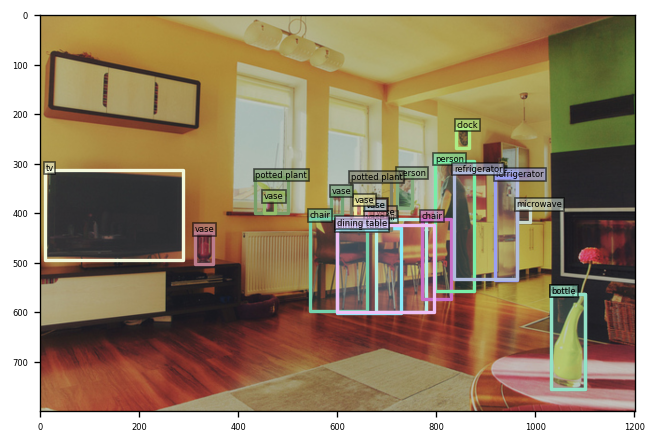

In [10]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# 2. Visualize Custom Images

In [11]:
from PIL import Image
import datasets.transforms as T

In [12]:
image = Image.open("./figs/idea.jpg").convert("RGB") # load image

In [13]:
# transform images
transform = T.Compose([
    T.RandomResize([800], max_size=1333),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image, _ = transform(image, None)

In [14]:
# predict images
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

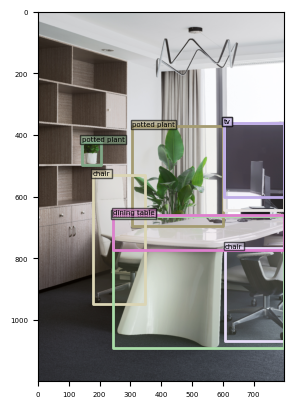

In [15]:
# visualize outputs
thershold = 0.3 # set a thershold

vslzr = COCOVisualizer()

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': torch.Tensor([image.shape[1], image.shape[2]]),
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None, dpi=100)